# Prophet Python Baseline

In [1]:
# load packages
import pandas as pd
import numpy as np
from fbprophet import Prophet
import os

import warnings

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)

In [556]:
os.path.join(os.getcwd(),"train.csv")

'C:\\Users\\tung_\\Desktop\\DSCI_591_capstone-Providence\\src\\..\\train.csv'

In [559]:
os.path.join(os.path.abspath("../data/train.csv"))

'C:\\Users\\tung_\\Desktop\\DSCI_591_capstone-Providence\\data\\train.csv'

# Necessary functions

In [2]:
# custom MAPE
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

# custom MAE
def mae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred)))

In [3]:
def run_prophet(series, timeframe):
    """
    Runs the Prophet 
    
    Key arguments:
    --------------
    series -- (DataFrame) time series data
    timeframe -- (DataFrame) a DataFrame with one column 
                 consisting of predicted dates

    Returns: 
    --------------
    Returns the forecast of the predictions 

    """
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
                    # changepoint_prior_scale=0.001,
                    # mcmc_samples=300,
                    interval_width=0.95)
    model.fit(series)
    forecast = model.predict(timeframe)
    return forecast, model

In [5]:
def aggregate_error(data, variable=None, method="mape"):
    """
    Given the combined data from our generated forecast and
    returns the aggregated error
    
    Key arguments:
    --------------
    data -- (dict) dictionary of data that we want to use
    variable -- (str) variable name
    method -- (str) mape or mae

    Returns: 
    --------------
    The aggregated MAPE or MAE of the forecast

    """
    test_pred = timeframe.copy()
    test_true = timeframe.copy()
    if variable is None:
        for i in data:
            test_pred = pd.merge(test_pred, data[i][["ds", "yhat"]], on="ds")
            test_true = pd.merge(test_true, data[i][["ds", "y"]], on="ds")
    else:
        for i in data:
            if variable in i:
                test_pred = pd.merge(test_pred, data[i][["ds", "yhat"]], on="ds")
                test_true = pd.merge(test_true, data[i][["ds", "y"]], on="ds")
    sum_pred = test_pred.sum(axis=1)
    sum_true = test_true.sum(axis=1)
    if method == "mape":
        return mape(sum_true, sum_pred)
    if method == "mae":
        return mae(sum_true, sum_pred)

In [7]:
# read data
raw_data = pd.read_csv("../data/train.csv", parse_dates=["SHIFT_DATE"])

/Users/patricktung/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.



In [8]:
# split data to train and val
train = raw_data[(raw_data["SHIFT_DATE"]>"2012-12-31") & (raw_data["SHIFT_DATE"]<"2017-01-01")]
val = raw_data[(raw_data["SHIFT_DATE"]>"2016-12-31") & (raw_data["SHIFT_DATE"]<"2018-01-01")]

# Split by Job Family and Site

In [9]:
# using only a portion of the sites
small_train = train[(train["SITE"]=="St Paul's Hospital") |
                    (train["SITE"]=="Mt St Joseph") |
                    (train["SITE"]=="Holy Family") |
                    (train["SITE"]=="SVH Langara") |
                    (train["SITE"]=="Brock Fahrni") |
                    (train["SITE"]=="Youville Residence")]
small_train = small_train[(small_train["JOB_FAMILY"]=="DC1000") |
                    (small_train["JOB_FAMILY"]=="DC2A00") |
                    (small_train["JOB_FAMILY"]=="DC2B00") ]

small_val = val[(val["SITE"]=="St Paul's Hospital") |
                (val["SITE"]=="Mt St Joseph") |
                (val["SITE"]=="Holy Family") |
                (val["SITE"]=="SVH Langara") |
                (val["SITE"]=="Brock Fahrni") |
                (val["SITE"]=="Youville Residence")]
small_val = small_val[(small_val["JOB_FAMILY"]=="DC1000") |
                    (small_val["JOB_FAMILY"]=="DC2A00") |
                    (small_val["JOB_FAMILY"]=="DC2B00") ]

In [473]:
# create training dataframes
splitting_train = small_train.groupby(["JOB_FAMILY", "SITE", "SHIFT_DATE"]).size().reset_index()
splitting_train = splitting_train.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

# create validation dataframes
splitting_val = small_val.groupby(["JOB_FAMILY", "SITE", "SHIFT_DATE"]).size().reset_index()
splitting_val = splitting_val.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [12]:
# create timeframe data for prediction
total_timeframe = pd.DataFrame(pd.date_range(start='2013-01-01', end='2016-12-31', freq="D")).rename({0:"ds"}, axis=1)
timeframe = pd.DataFrame(pd.date_range(start='2017-01-01', end='2017-12-31', freq="D")).rename({0:"ds"}, axis=1)

In [13]:
small_sites = small_train["SITE"].unique()
small_jfs = small_train["JOB_FAMILY"].unique()

In [367]:
warnings.simplefilter('ignore')
# create and store predictions and true results
models = {}
split_data = {}
pred_results_past = {}
pred_results_future = {}
true_results = {}
for i in small_sites:
    for j in small_jfs:
        temp_data_train = splitting_train[(splitting_train["SITE"]==i) & (splitting_train["JOB_FAMILY"]==j)].reset_index()
        temp_data_train = pd.merge(total_timeframe, temp_data_train, on="ds", how="outer")
        temp_data_train["y"] = temp_data_train["y"].fillna(0)
        
        temp_data_val = splitting_val[(splitting_val["SITE"]==i) & (splitting_val["JOB_FAMILY"]==j)].reset_index(drop=True)
        temp_data_val = pd.merge(timeframe, temp_data_val, on="ds", how="outer")
        temp_data_val["y"] = temp_data_val["y"].fillna(0)
        
        split_data[(i, j)] = temp_data_train
        true_results[(i, j)] = temp_data_val
        pred_results_past[(i, j)], models[(i,j)] = run_prophet(temp_data_train, total_timeframe)
        pred_results_future[(i, j)] = models[(i,j)].predict(timeframe)
        print("Fitting -", i, j, ": Done")

Fitting - St Paul's Hospital DC1000 : Done
Fitting - St Paul's Hospital DC2B00 : Done
Fitting - St Paul's Hospital DC2A00 : Done
Fitting - SVH Langara DC1000 : Done
Fitting - SVH Langara DC2B00 : Done
Fitting - SVH Langara DC2A00 : Done
Fitting - Mt St Joseph DC1000 : Done
Fitting - Mt St Joseph DC2B00 : Done
Fitting - Mt St Joseph DC2A00 : Done
Fitting - Brock Fahrni DC1000 : Done
Fitting - Brock Fahrni DC2B00 : Done
Fitting - Brock Fahrni DC2A00 : Done
Fitting - Holy Family DC1000 : Done
Fitting - Holy Family DC2B00 : Done
Fitting - Holy Family DC2A00 : Done
Fitting - Youville Residence DC1000 : Done
Fitting - Youville Residence DC2B00 : Done
Fitting - Youville Residence DC2A00 : Done


## Get weekly errors

In [369]:
# combine predictions and true results
combined = {}
for i in true_results:
    if pred_results_future[i] is not None:
        combined[i] = pd.merge(true_results[i], 
                               pred_results_future[i], 
                               on="ds", 
                               how="outer")[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]]

In [391]:
# convert to week and calculating errors weekly
weekly = {}
for i in combined:
    # create week column
    combined[i]["ds"] = combined[i]["ds"]-pd.DateOffset(weekday=0, weeks=1)
    combined[i]["week"] = combined[i]["ds"].dt.week

    # store y, yhat, yhat_lower, yhat_upper
    weekly_y = combined[i].groupby("ds").y.sum().reset_index()
    weekly_yhat = combined[i].groupby("ds").yhat.sum().round(0).astype(int).reset_index()
    weekly_yhat_lower = combined[i].groupby("ds").yhat_lower.sum().round(0).astype(int).reset_index()
    weekly_yhat_upper = combined[i].groupby("ds").yhat_upper.sum().round(0).astype(int).reset_index()

    # replace negative prediction values with 0
    weekly_yhat = weekly_yhat.where(weekly_yhat["yhat"] >= 0, 0)
    weekly_yhat_lower = weekly_yhat_lower.where(weekly_yhat_lower["yhat_lower"] >= 0, 0)
    weekly_yhat_upper = weekly_yhat_upper.where(weekly_yhat_upper["yhat_upper"] >= 0, 0)


    # merge weekly results
    weekly[i] = pd.concat([weekly_y, weekly_yhat["yhat"],
                           weekly_yhat_lower["yhat_lower"],
                           weekly_yhat_upper["yhat_upper"]],
                          axis=1)

    # create columns "year", "site", "JOB_FAMILY"
    length = weekly[i].shape[0]
    weekly[i]["week"] = weekly[i]["ds"].dt.weekofyear
    weekly[i]["site"] = np.repeat(i[0], length)
    weekly[i]["job_family"] = np.repeat(i[1], length)

In [392]:
for i in weekly:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly[i]["y"], weekly[i]["yhat"]), 
                                         mae(weekly[i]["y"], weekly[i]["yhat"])))

("St Paul's Hospital", 'DC1000'): MAPE: 5.164288029331788, MAE: 100.64150943396227
("St Paul's Hospital", 'DC2B00'): MAPE: 24.20941722668481, MAE: 18.264150943396228
("St Paul's Hospital", 'DC2A00'): MAPE: 32.5758445361709, MAE: 38.43396226415094
('SVH Langara', 'DC1000'): MAPE: 20.49649722444216, MAE: 9.566037735849056
('SVH Langara', 'DC2B00'): MAPE: inf, MAE: 1.1886792452830188
('SVH Langara', 'DC2A00'): MAPE: inf, MAE: 4.90566037735849
('Mt St Joseph', 'DC1000'): MAPE: 13.093594261071328, MAE: 38.24528301886792
('Mt St Joseph', 'DC2B00'): MAPE: inf, MAE: 5.773584905660377
('Mt St Joseph', 'DC2A00'): MAPE: 48.20761297529101, MAE: 8.49056603773585
('Brock Fahrni', 'DC1000'): MAPE: 23.184243084027305, MAE: 6.113207547169812
('Brock Fahrni', 'DC2B00'): MAPE: inf, MAE: 1.5660377358490567
('Brock Fahrni', 'DC2A00'): MAPE: inf, MAE: 3.207547169811321
('Holy Family', 'DC1000'): MAPE: 22.249402953360526, MAE: 14.50943396226415
('Holy Family', 'DC2B00'): MAPE: inf, MAE: 1.490566037735849
('H

In [393]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

St Paul's Hospital: MAPE: 4.423017859986734, MAE: 102.45098039215686
SVH Langara: MAPE: 23.296665910173868, MAE: 11.490196078431373
Mt St Joseph: MAPE: 11.84669914863889, MAE: 44.01960784313726
Brock Fahrni: MAPE: 20.23465861811913, MAE: 8.764705882352942
Holy Family: MAPE: 21.68574371053305, MAE: 15.882352941176471
Youville Residence: MAPE: 17.385198412413555, MAE: 8.137254901960784


In [394]:
# errors for each labor agreement
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

DC1000: MAPE: 4.590198853601259, MAE: 121.2156862745098
DC2B00: MAPE: 15.27281900170738, MAE: 18.901960784313726
DC2A00: MAPE: 30.380039840599736, MAE: 47.92156862745098


In [395]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly, method="mape"), 
                                             aggregate_error(weekly, method="mae")))

Total MAPE: 4.528495118505118
Total MAE: 130.7058823529412


# Minimize error


In [396]:
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)


In [397]:
for i in weekly:
    forecasted = pred_results_past[i]
    actual = split_data[i]

    error = actual["y"] - forecasted["yhat"]
    obs = total_timeframe.copy()
    obs["error"] = error
    obs = obs.set_index("ds")

    decomp = decompose(obs, period=365)
    weekly_fcast = forecast(decomp, steps=365, fc_func=drift, seasonal=True)
    weekly_fcast["week"] = weekly_fcast.index-pd.DateOffset(weekday=0, weeks=1)
    weekly_fcast = weekly_fcast.groupby("week").sum()

    resid_fcast = weekly_fcast.reset_index()["drift+seasonal"]
    weekly_yhat = (weekly[i]["yhat"] + resid_fcast).round(0)
    weekly_yhat_lower = (weekly[i]["yhat_lower"] + resid_fcast).round(0)
    weekly_yhat_upper = (weekly[i]["yhat_upper"] + resid_fcast).round(0)

    weekly[i]["yhat"] = weekly_yhat.where(weekly_yhat >= 0, 0)
    weekly[i]["yhat_lower"] = weekly_yhat_lower.where(weekly_yhat_lower >= 0, 0)
    weekly[i]["yhat_upper"] = weekly_yhat_upper.where(weekly_yhat_upper >= 0, 0)

# Print new errors

In [398]:
for i in weekly:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly[i]["y"], weekly[i]["yhat"]), 
                                         mae(weekly[i]["y"], weekly[i]["yhat"])))

("St Paul's Hospital", 'DC1000'): MAPE: 4.206521926903699, MAE: 78.66037735849056
("St Paul's Hospital", 'DC2B00'): MAPE: 29.085851953243473, MAE: 18.471698113207548
("St Paul's Hospital", 'DC2A00'): MAPE: 32.95885190233128, MAE: 38.58490566037736
('SVH Langara', 'DC1000'): MAPE: 20.661273582965272, MAE: 10.226415094339623
('SVH Langara', 'DC2B00'): MAPE: inf, MAE: 1.3018867924528301
('SVH Langara', 'DC2A00'): MAPE: inf, MAE: 4.30188679245283
('Mt St Joseph', 'DC1000'): MAPE: 14.51027917462437, MAE: 39.886792452830186
('Mt St Joseph', 'DC2B00'): MAPE: inf, MAE: 5.60377358490566
('Mt St Joseph', 'DC2A00'): MAPE: 46.548349510007085, MAE: 8.377358490566039
('Brock Fahrni', 'DC1000'): MAPE: 24.41204540574981, MAE: 6.7924528301886795
('Brock Fahrni', 'DC2B00'): MAPE: inf, MAE: 1.5471698113207548
('Brock Fahrni', 'DC2A00'): MAPE: inf, MAE: 3.3773584905660377
('Holy Family', 'DC1000'): MAPE: 23.99801041594299, MAE: 15.849056603773585
('Holy Family', 'DC2B00'): MAPE: inf, MAE: 1.66037735849056

In [399]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

St Paul's Hospital: MAPE: 3.6638116597630193, MAE: 84.13725490196079
SVH Langara: MAPE: 19.182267344843986, MAE: 10.235294117647058
Mt St Joseph: MAPE: 12.179255296743037, MAE: 45.84313725490196
Brock Fahrni: MAPE: 21.473827195514247, MAE: 9.372549019607844
Holy Family: MAPE: 22.911476241893762, MAE: 17.96078431372549
Youville Residence: MAPE: 21.351446374800137, MAE: 10.647058823529411


In [400]:
# errors for each labor agreement
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

DC1000: MAPE: 3.885015236573383, MAE: 101.52941176470588
DC2B00: MAPE: 16.018114090632483, MAE: 19.745098039215687
DC2A00: MAPE: 27.283468241081977, MAE: 43.23529411764706


In [401]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly, method="mape"), 
                                             aggregate_error(weekly, method="mae")))

Total MAPE: 3.782153229071676
Total MAE: 108.7843137254902


### Run below code to export tables

In [25]:
# create data/predictions folder if it doesn't exist
predictions_path = "../data/predictions/"
if not os.path.exists(predictions_path):
    os.mkdir(predictions_path)


# export to "data/predictions/" directory
total_data = pd.DataFrame()
for i in weekly:
    total_data = pd.concat([total_data, weekly[i]], axis=0)
total_data.to_csv(predictions_path + "predictions.csv")

# Split by Job Family, Site, and Sub Program

In [16]:
small_programs = small_train["SUB_PROGRAM"].unique()

In [30]:
len(small_programs)

# total = 6 sites * 3 job families * 66 sub programs = 1188

66

In [17]:
# create training dataframes
splitting_train2 = small_train.groupby(["JOB_FAMILY", "SITE", "SUB_PROGRAM", "SHIFT_DATE"]).size().reset_index()
splitting_train2 = splitting_train2.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

# create validation dataframes
splitting_val2 = small_val.groupby(["JOB_FAMILY", "SITE", "SUB_PROGRAM", "SHIFT_DATE"]).size().reset_index()
splitting_val2 = splitting_val2.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [18]:
warnings.simplefilter('ignore')
# create and store predictions and true results
models2 = {}
split_data2 = {}
pred_results_past2 = {}
pred_results_future2 = {}
true_results2 = {}
for i in small_sites:
    for j in small_jfs:
        for k in small_programs:
            temp_data_train = splitting_train2[(splitting_train2["SITE"]==i) & (splitting_train2["JOB_FAMILY"]==j) & (splitting_train2["SUB_PROGRAM"]==k)].reset_index()
            temp_data_train = pd.merge(total_timeframe, temp_data_train, on="ds", how="outer")
            temp_data_train["y"] = temp_data_train["y"].fillna(0)

            temp_data_val = splitting_val2[(splitting_val2["SITE"]==i) & (splitting_val2["JOB_FAMILY"]==j) & (splitting_val2["SUB_PROGRAM"]==k)].reset_index(drop=True)
            temp_data_val = pd.merge(timeframe, temp_data_val, on="ds", how="outer")
            temp_data_val["y"] = temp_data_val["y"].fillna(0)

            split_data2[(i, j, k)] = temp_data_train
            true_results2[(i, j, k)] = temp_data_val
            if temp_data_val["y"].sum() >= 300.0:
                pred_results_past2[(i, j, k)], models2[(i, j, k)] = run_prophet(temp_data_train, total_timeframe)
                pred_results_future2[(i, j, k)] = models2[(i, j, k)].predict(timeframe)
                print("Fitting -", i, j, k, ": Done")

Fitting - St Paul's Hospital DC1000 HEMODIALYSIS 6CD IC : Done
Fitting - St Paul's Hospital DC1000 RENAL CDU IAMHD : Done
Fitting - St Paul's Hospital DC1000 SPH INPATIENT : Done
Fitting - St Paul's Hospital DC1000 OR PAR SPH : Done
Fitting - St Paul's Hospital DC1000 BARBARA HALL : Done
Fitting - St Paul's Hospital DC1000 ICU : Done
Fitting - St Paul's Hospital DC1000 NURSING UNIT SPH : Done
Fitting - St Paul's Hospital DC1000 10C, CLINICS : Done
Fitting - St Paul's Hospital DC1000 DIONNE NORDBY : Done
Fitting - St Paul's Hospital DC1000 MED NURSE RELIEF : Done
Fitting - St Paul's Hospital DC1000 PALLIATIVE SRVCS : Done
Fitting - St Paul's Hospital DC1000 NICU MATERNITY : Done
Fitting - St Paul's Hospital DC1000 EMERG SPH : Done
Fitting - St Paul's Hospital DC1000 LR COMP CLASS : Done
Fitting - St Paul's Hospital DC1000 MELANIE MULDER : Done
Fitting - St Paul's Hospital DC1000 PASU 9A 2N 8C : Done
Fitting - St Paul's Hospital DC1000 SPH CLINICS : Done
Fitting - St Paul's Hospital DC10

In [19]:
counter = {}
for i in true_results2:
    counter[i] = true_results2[i]["y"].sum()
    
for w in sorted(counter, key=counter.get, reverse=True):
    print(w, counter[w])

("St Paul's Hospital", 'DC1000', 'OR PAR SPH') 15703
("St Paul's Hospital", 'DC1000', 'MELANIE MULDER') 9941
("St Paul's Hospital", 'DC1000', 'EMERG SPH') 8637
("St Paul's Hospital", 'DC1000', 'ICU') 7628
("St Paul's Hospital", 'DC1000', 'HEMODIALYSIS 6CD IC') 6962
('Mt St Joseph', 'DC1000', 'MSJ OR PAR DT CL') 6769.0
("St Paul's Hospital", 'DC1000', 'BARBARA HALL') 6627
("St Paul's Hospital", 'DC1000', 'NURSING UNIT SPH') 5964
("St Paul's Hospital", 'DC1000', 'PASU 9A 2N 8C') 5741
("St Paul's Hospital", 'DC1000', 'MED NURSE RELIEF') 4751
("St Paul's Hospital", 'DC1000', 'SPH INPATIENT') 4643
('Mt St Joseph', 'DC1000', 'MSJ NURSING UNITS') 4557
("St Paul's Hospital", 'DC1000', '10C, CLINICS') 4413
("St Paul's Hospital", 'DC1000', 'NICU MATERNITY') 4350
("St Paul's Hospital", 'DC1000', 'RENAL CDU IAMHD') 3462.0
("St Paul's Hospital", 'DC1000', 'RENAL 6AB') 3202.0
("St Paul's Hospital", 'DC1000', 'DIONNE NORDBY') 2968
("St Paul's Hospital", 'DC1000', 'SPH CLINICS') 2506
('Mt St Joseph', 

## Weekly errors

In [57]:
# combine predictions and true results
combined2 = {}
for i in pred_results_future2:
    if pred_results_future2[i] is not None:
        combined2[i] = pd.merge(true_results2[i], 
                               pred_results_future2[i], 
                               on="ds", 
                               how="outer")[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]]

In [58]:
# convert to week and calculating errors weekly
weekly2 = {}
for i in combined2:
    # create week column
    combined2[i]["ds"] = combined2[i]["ds"]-pd.DateOffset(weekday=0, weeks=1)
    combined2[i]["week"] = combined2[i]["ds"].dt.week

    # store y, yhat, yhat_lower, yhat_upper
    weekly_y = combined2[i].groupby("ds").y.sum().reset_index()
    weekly_yhat = combined2[i].groupby("ds").yhat.sum().round(0).astype(int).reset_index()
    weekly_yhat_lower = combined2[i].groupby("ds").yhat_lower.sum().round(0).astype(int).reset_index()
    weekly_yhat_upper = combined2[i].groupby("ds").yhat_upper.sum().round(0).astype(int).reset_index()

    # replace negative prediction values with 0
    weekly_yhat = weekly_yhat.where(weekly_yhat["yhat"] >= 0, 0)
    weekly_yhat_lower = weekly_yhat_lower.where(weekly_yhat_lower["yhat_lower"] >= 0, 0)
    weekly_yhat_upper = weekly_yhat_upper.where(weekly_yhat_upper["yhat_upper"] >= 0, 0)


    # merge weekly results
    weekly2[i] = pd.concat([weekly_y, weekly_yhat["yhat"],
                           weekly_yhat_lower["yhat_lower"],
                           weekly_yhat_upper["yhat_upper"]],
                          axis=1)

    # create columns "year", "site", "job_family", "sub_program"
    length = weekly2[i].shape[0]
    weekly2[i]["week"] = weekly2[i]["ds"].dt.weekofyear
    weekly2[i]["site"] = np.repeat(i[0], length)
    weekly2[i]["job_family"] = np.repeat(i[1], length)
    weekly2[i]["program"] = np.repeat(i[2], length)
    
    

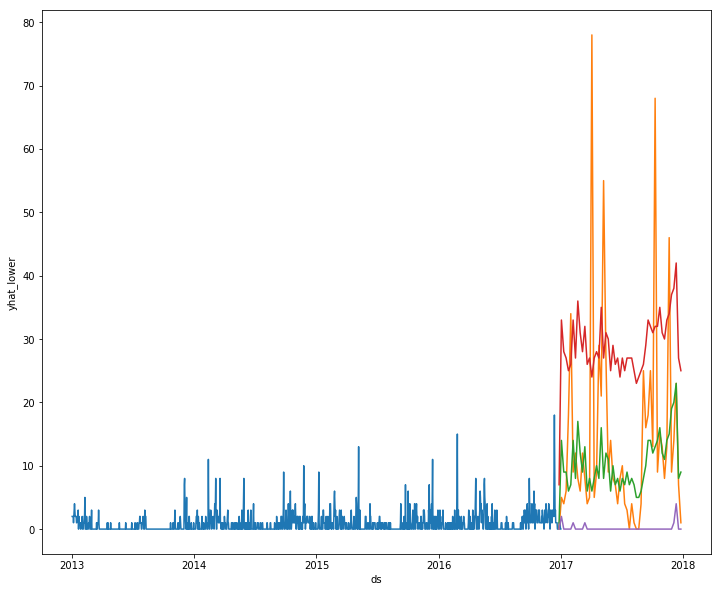

In [76]:
var = ("St Paul's Hospital", 'DC1000', 'LR COMP CLASS')
plot_data = weekly2[var]
plot_past = split_data2[var]

ax = plt.subplots(figsize=(12,10))
ax = sns.lineplot(data= plot_past, x="ds", y="y")
ax = sns.lineplot(data= plot_data, x="ds", y="y")
ax = sns.lineplot(data= plot_data, x="ds", y="yhat")
ax = sns.lineplot(data= plot_data, x="ds", y="yhat_upper")
ax = sns.lineplot(data= plot_data, x="ds", y="yhat_lower")

In [60]:
for i in weekly2:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly2[i]["y"], weekly2[i]["yhat"]), 
                                         mae(weekly2[i]["y"], weekly2[i]["yhat"])))

("St Paul's Hospital", 'DC1000', 'HEMODIALYSIS 6CD IC'): MAPE: 6.971410452037653, MAE: 9.037735849056604
("St Paul's Hospital", 'DC1000', 'RENAL CDU IAMHD'): MAPE: 21.364034345781054, MAE: 14.660377358490566
("St Paul's Hospital", 'DC1000', 'SPH INPATIENT'): MAPE: 11.938888872455031, MAE: 10.50943396226415
("St Paul's Hospital", 'DC1000', 'OR PAR SPH'): MAPE: 8.194013846136986, MAE: 22.50943396226415
("St Paul's Hospital", 'DC1000', 'BARBARA HALL'): MAPE: 13.827754463752603, MAE: 16.566037735849058
("St Paul's Hospital", 'DC1000', 'ICU'): MAPE: 11.420849522895185, MAE: 16.50943396226415
("St Paul's Hospital", 'DC1000', 'NURSING UNIT SPH'): MAPE: 13.130276661400334, MAE: 14.88679245283019
("St Paul's Hospital", 'DC1000', '10C, CLINICS'): MAPE: 19.99777128020912, MAE: 17.71698113207547
("St Paul's Hospital", 'DC1000', 'DIONNE NORDBY'): MAPE: 18.7793614389054, MAE: 10.30188679245283
("St Paul's Hospital", 'DC1000', 'MED NURSE RELIEF'): MAPE: 11.975890412482254, MAE: 10.11320754716981
("St

In [61]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

St Paul's Hospital: MAPE: 4.258730393542394, MAE: 94.07692307692308
SVH Langara: MAPE: 19.99067206515825, MAE: 9.76923076923077
Mt St Joseph: MAPE: 10.814159934096729, MAE: 38.23076923076923
Brock Fahrni: MAPE: 16.96848454983377, MAE: 6.115384615384615
Holy Family: MAPE: 22.090819206297628, MAE: 14.788461538461538
Youville Residence: MAPE: 17.83623944581096, MAE: 7.9423076923076925


In [62]:
# errors for each labor agreement
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

DC1000: MAPE: 4.570543532009783, MAE: 120.38461538461539
DC2B00: MAPE: 22.211368588763904, MAE: 11.115384615384615
DC2A00: MAPE: 45.068394480701116, MAE: 39.57692307692308


In [63]:
# errors for each labor agreement
for i in small_programs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

HEMODIALYSIS 6CD IC: MAPE: 6.7416506738283974, MAE: 9.076923076923077
RENAL CDU IAMHD: MAPE: 14.989466449721057, MAE: 11.692307692307692
SPH INPATIENT: MAPE: 11.489749857558804, MAE: 10.596153846153847
OR PAR SPH: MAPE: 7.7945561849182665, MAE: 25.557692307692307
RES SVCS LAN: MAPE: 24.689617383494305, MAE: 8.961538461538462
BARBARA HALL: MAPE: 11.006752737518042, MAE: 14.826923076923077
ICU: MAPE: 10.59395245128504, MAE: 19.903846153846153
NURSING UNIT SPH: MAPE: 16.32272279256877, MAE: 18.423076923076923
10C, CLINICS: MAPE: 19.632623396602742, MAE: 19.634615384615383
DIONNE NORDBY: MAPE: 17.422638186124203, MAE: 12.384615384615385
MSJ NURSING UNITS: MAPE: 15.06147639887015, MAE: 12.307692307692308
PARKVIEW, 1 SOUTH: MAPE: 14.73962605832527, MAE: 9.326923076923077
MED NURSE RELIEF: MAPE: 11.85654564768733, MAE: 10.23076923076923
PALLIATIVE SRVCS: MAPE: 26.5188450658813, MAE: 4.961538461538462
ACCESS SVCS MSJ: MAPE: 38.632094401325176, MAE: 1.9423076923076923
NICU MATERNITY: MAPE: 15.3

In [64]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly2, method="mape"), 
                                             aggregate_error(weekly2, method="mae")))

Total MAPE: 4.380573494864766
Total MAE: 120.34615384615384


# Minimize error

In [65]:
for i in pred_results_future2:
    if "St Paul's Hospital" in i:
        forecasted = pred_results_past2[i]
        actual = split_data2[i]

        error = actual["y"] - forecasted["yhat"]
        obs = total_timeframe.copy()
        obs["error"] = error
        obs = obs.set_index("ds")

        decomp = decompose(obs, period=365)
        weekly_fcast = forecast(decomp, steps=365, fc_func=drift, seasonal=True)
        weekly_fcast["week"] = weekly_fcast.index-pd.DateOffset(weekday=0, weeks=1)
        weekly_fcast = weekly_fcast.groupby("week").sum()

        resid_fcast = weekly_fcast.reset_index()["drift+seasonal"]
        weekly_yhat = (weekly2[i]["yhat"] + resid_fcast).round(0)
        weekly_yhat_lower = (weekly2[i]["yhat_lower"] + resid_fcast).round(0)
        weekly_yhat_upper = (weekly2[i]["yhat_upper"] + resid_fcast).round(0)

        weekly2[i]["yhat"] = weekly_yhat.where(weekly_yhat >= 0, 0)
        weekly2[i]["yhat_lower"] = weekly_yhat_lower.where(weekly_yhat_lower >= 0, 0)
        weekly2[i]["yhat_upper"] = weekly_yhat_upper.where(weekly_yhat_upper >= 0, 0)

# Print new errors

In [66]:
for i in weekly2:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly2[i]["y"], weekly2[i]["yhat"]), 
                                         mae(weekly2[i]["y"], weekly2[i]["yhat"])))

("St Paul's Hospital", 'DC1000', 'HEMODIALYSIS 6CD IC'): MAPE: 8.219195014059338, MAE: 10.377358490566039
("St Paul's Hospital", 'DC1000', 'RENAL CDU IAMHD'): MAPE: 20.703261455815703, MAE: 14.339622641509434
("St Paul's Hospital", 'DC1000', 'SPH INPATIENT'): MAPE: 13.414598832962184, MAE: 12.20754716981132
("St Paul's Hospital", 'DC1000', 'OR PAR SPH'): MAPE: 8.314071817842652, MAE: 22.09433962264151
("St Paul's Hospital", 'DC1000', 'BARBARA HALL'): MAPE: 14.305707669582318, MAE: 17.30188679245283
("St Paul's Hospital", 'DC1000', 'ICU'): MAPE: 10.914341587615601, MAE: 16.49056603773585
("St Paul's Hospital", 'DC1000', 'NURSING UNIT SPH'): MAPE: 14.097613019873073, MAE: 16.32075471698113
("St Paul's Hospital", 'DC1000', '10C, CLINICS'): MAPE: 22.102834857408197, MAE: 19.49056603773585
("St Paul's Hospital", 'DC1000', 'DIONNE NORDBY'): MAPE: 19.761161724963227, MAE: 11.169811320754716
("St Paul's Hospital", 'DC1000', 'MED NURSE RELIEF'): MAPE: 11.697613151629204, MAE: 9.90566037735849
(

In [67]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

St Paul's Hospital: MAPE: 4.8243315127401365, MAE: 107.57692307692308
SVH Langara: MAPE: 19.99067206515825, MAE: 9.76923076923077
Mt St Joseph: MAPE: 10.814159934096729, MAE: 38.23076923076923
Brock Fahrni: MAPE: 16.96848454983377, MAE: 6.115384615384615
Holy Family: MAPE: 22.090819206297628, MAE: 14.788461538461538
Youville Residence: MAPE: 17.83623944581096, MAE: 7.9423076923076925


In [68]:
# errors for each job family
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

DC1000: MAPE: 4.805085377956224, MAE: 127.32692307692308
DC2B00: MAPE: 24.635213689852083, MAE: 12.596153846153847
DC2A00: MAPE: 33.420138543947424, MAE: 28.807692307692307


In [69]:
# errors for each job family
for i in small_programs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

HEMODIALYSIS 6CD IC: MAPE: 7.5976306770116215, MAE: 10.288461538461538
RENAL CDU IAMHD: MAPE: 16.35560439589354, MAE: 13.01923076923077
SPH INPATIENT: MAPE: 13.106961027713721, MAE: 12.346153846153847
OR PAR SPH: MAPE: 8.113339942711416, MAE: 26.0
RES SVCS LAN: MAPE: 24.689617383494305, MAE: 8.961538461538462
BARBARA HALL: MAPE: 11.658425972508415, MAE: 15.634615384615385
ICU: MAPE: 8.945623171070268, MAE: 17.403846153846153
NURSING UNIT SPH: MAPE: 14.845913972401101, MAE: 17.134615384615383
10C, CLINICS: MAPE: 21.875973707079282, MAE: 21.634615384615383
DIONNE NORDBY: MAPE: 18.474671716983142, MAE: 13.365384615384615
MSJ NURSING UNITS: MAPE: 15.06147639887015, MAE: 12.307692307692308
PARKVIEW, 1 SOUTH: MAPE: 14.73962605832527, MAE: 9.326923076923077
MED NURSE RELIEF: MAPE: 11.310679138810885, MAE: 9.961538461538462
PALLIATIVE SRVCS: MAPE: 28.468590037666857, MAE: 5.230769230769231
ACCESS SVCS MSJ: MAPE: 38.632094401325176, MAE: 1.9423076923076923
NICU MATERNITY: MAPE: 15.3620597352815

In [70]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly2, method="mape"), 
                                             aggregate_error(weekly2, method="mae")))

Total MAPE: 4.248221906859366
Total MAE: 118.42307692307692


### Run below code to export tables

In [73]:
# create data/predictions folder if it doesn't exist
predictions_path = "../data/predictions/"
if not os.path.exists(predictions_path):
    os.mkdir(predictions_path)


# export to "data/predictions/" directory
total_data = pd.DataFrame()
for i in weekly2:
    total_data = pd.concat([total_data, weekly2[i]], axis=0)
total_data.to_csv(predictions_path + "predictions_subprogram2.csv")

# Save to pickle

In [527]:
import pickle

pickle_out = open("../data/predictions/program_models.pickle","wb")
pickle.dump(models2, pickle_out)
pickle_out.close()

# Load pickle

In [274]:
pickle_in = open("../data/predictions/subprogram_models.pickle","rb")
models2 = pickle.load(pickle_in)